# 1 Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid, GridSearchCV
from sklearn.metrics import silhouette_score, make_scorer

In [2]:
base_clientes = pd.read_csv('../Docs/Olist_Datasets/olist_customers_dataset.csv')
base_item_pedido = pd.read_csv('../Docs/Olist_Datasets/olist_order_items_dataset.csv')
base_pedido = pd.read_csv('../Docs/Olist_Datasets/olist_orders_dataset.csv')
base_produtos = pd.read_csv('../Docs/Olist_Datasets/olist_products_dataset.csv')

# 2. Pré Processamento

Segundo a documentação, temos que 
- Clientes é único, utilizada para achar a localização do pedido, bem como conectar os pedidos aos clientes
- Item pedido tem informações dos produtos de cada pedido bem como qtde dos produtos
- Pedido é a core, cada linha é um pedido único
- Produtos é cada linha um produto

## Formatos

In [3]:
base_clientes.shape

(99441, 5)

In [4]:
base_clientes.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [5]:
base_clientes.dtypes

customer_id                 object
customer_unique_id          object
customer_zip_code_prefix     int64
customer_city               object
customer_state              object
dtype: object

Ok

In [6]:
base_item_pedido.shape

(112650, 7)

In [7]:
base_item_pedido.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [8]:
base_item_pedido.dtypes

order_id                object
order_item_id            int64
product_id              object
seller_id               object
shipping_limit_date     object
price                  float64
freight_value          float64
dtype: object

In [9]:
base_item_pedido.shipping_limit_date = pd.to_datetime(base_item_pedido.shipping_limit_date,
                                                      format='%Y-%m-%d %H:%M:%S')

In [10]:
base_item_pedido.dtypes

order_id                       object
order_item_id                   int64
product_id                     object
seller_id                      object
shipping_limit_date    datetime64[ns]
price                         float64
freight_value                 float64
dtype: object

Ok

In [11]:
base_pedido.shape

(99441, 8)

In [12]:
base_pedido.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [13]:
base_pedido.dtypes

order_id                         object
customer_id                      object
order_status                     object
order_purchase_timestamp         object
order_approved_at                object
order_delivered_carrier_date     object
order_delivered_customer_date    object
order_estimated_delivery_date    object
dtype: object

In [14]:
base_pedido.order_purchase_timestamp = pd.to_datetime(base_pedido.order_purchase_timestamp,
                                                      format='%Y-%m-%d %H:%M:%S')
base_pedido.order_approved_at = pd.to_datetime(base_pedido.order_approved_at,
                                                      format='%Y-%m-%d %H:%M:%S')
base_pedido.order_delivered_carrier_date = pd.to_datetime(base_pedido.order_delivered_carrier_date,
                                                      format='%Y-%m-%d %H:%M:%S')
base_pedido.order_delivered_customer_date = pd.to_datetime(base_pedido.order_delivered_customer_date,
                                                      format='%Y-%m-%d %H:%M:%S')
base_pedido.order_estimated_delivery_date = pd.to_datetime(base_pedido.order_estimated_delivery_date,
                                                      format='%Y-%m-%d %H:%M:%S')

In [15]:
base_pedido.dtypes

order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
dtype: object

Ok

In [16]:
base_produtos.shape

(32951, 9)

In [17]:
base_produtos.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


In [18]:
base_produtos.dtypes

product_id                     object
product_category_name          object
product_name_lenght           float64
product_description_lenght    float64
product_photos_qty            float64
product_weight_g              float64
product_length_cm             float64
product_height_cm             float64
product_width_cm              float64
dtype: object

Ok

## Missing Values

In [19]:
base_clientes.isna().sum().sum()

0

In [20]:
base_item_pedido.isna().sum().sum()

0

In [21]:
base_pedido.isna().sum().sum()

4908

In [22]:
base_pedido.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Todos os missing deste dataset são datas, talvez relacionada ao status?

In [23]:
base_pedido[base_pedido.order_approved_at.isna()].order_status.value_counts()

order_status
canceled     141
delivered     14
created        5
Name: count, dtype: int64

Podemos observar que a maioria dos casos está correta, pois são pedidos cancelados e criados.
Sendo assim, podemos retirar os casos em que o pedido foi entregue e não temos a data de aprorvação do pagamento

In [24]:
base_pedido[base_pedido.order_delivered_carrier_date.isna()].order_status.value_counts()

order_status
unavailable    609
canceled       550
invoiced       314
processing     301
created          5
approved         2
delivered        2
Name: count, dtype: int64

Assim como podemos notar acima, são casos em que não foi possivel entregar ao cliente ou ainda não foram entregues. Podemos descartar como "errados" apenas os casos que foram entregues e não temos a data de manipulação da logística

In [25]:
base_pedido[base_pedido.order_delivered_customer_date.isna()].order_status.value_counts()


order_status
shipped        1107
canceled        619
unavailable     609
invoiced        314
processing      301
delivered         8
created           5
approved          2
Name: count, dtype: int64

Idem item anteriror.

In [26]:
base_pedido[base_pedido.order_status == "delivered"].isna().sum()

order_id                          0
customer_id                       0
order_status                      0
order_purchase_timestamp          0
order_approved_at                14
order_delivered_carrier_date      2
order_delivered_customer_date     8
order_estimated_delivery_date     0
dtype: int64

In [27]:
base_pedido2 = base_pedido.drop(base_pedido[((base_pedido.order_status == "delivered")
                                            & (base_pedido.order_approved_at.isna()))
                                            |((base_pedido.order_status == "delivered")
                                            & (base_pedido.order_delivered_carrier_date.isna()))
                                            |((base_pedido.order_status == "delivered")
                                            & (base_pedido.order_delivered_customer_date.isna()))].index)

In [28]:
base_pedido2[base_pedido2.order_status == "delivered"].isna().sum()

order_id                         0
customer_id                      0
order_status                     0
order_purchase_timestamp         0
order_approved_at                0
order_delivered_carrier_date     0
order_delivered_customer_date    0
order_estimated_delivery_date    0
dtype: int64

In [29]:
base_pedido.shape[0]-base_pedido2.shape[0]

23

Ok

In [30]:
base_produtos.isna().sum().sum()

2448

In [31]:
base_produtos.isna().sum()

product_id                      0
product_category_name         610
product_name_lenght           610
product_description_lenght    610
product_photos_qty            610
product_weight_g                2
product_length_cm               2
product_height_cm               2
product_width_cm                2
dtype: int64

Uma vez que essas informações são cruciais para fazermos nossa análise, teremos que retirar esses casos de nossa base

In [32]:
base_produtos2 = base_produtos.drop(base_produtos[(base_produtos.product_category_name.isna())|
                                                  (base_produtos.product_weight_g.isna())].index)

In [33]:
base_produtos2.isna().sum()

product_id                    0
product_category_name         0
product_name_lenght           0
product_description_lenght    0
product_photos_qty            0
product_weight_g              0
product_length_cm             0
product_height_cm             0
product_width_cm              0
dtype: int64

In [34]:
base_produtos.shape[0] - base_produtos2.shape[0]

611

Ok

## Duplicados

In [35]:
base_clientes.customer_id.duplicated(keep='first').sum()

0

In [36]:
base_item_pedido.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [37]:
base_item_pedido.duplicated(subset=['order_id','product_id','seller_id'],keep=False).sum()

17313

In [38]:
base_item_pedido[base_item_pedido.duplicated(subset=['order_id','product_id','seller_id'],keep=False)].sort_values(by='order_id').head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
13,0008288aa423d2a3f00fcb17cd7d8719,1,368c6c730842d78016ad823897a372db,1f50f920176fa81dab994f9023523100,2018-02-21 02:55:52,49.90,13.37
14,0008288aa423d2a3f00fcb17cd7d8719,2,368c6c730842d78016ad823897a372db,1f50f920176fa81dab994f9023523100,2018-02-21 02:55:52,49.90,13.37
32,00143d0f86d6fbd9f9b38ab440ac16f5,1,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.10
33,00143d0f86d6fbd9f9b38ab440ac16f5,2,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.10
34,00143d0f86d6fbd9f9b38ab440ac16f5,3,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.10


In [39]:
base_item_pedido[base_item_pedido.order_id == "00143d0f86d6fbd9f9b38ab440ac16f5"]

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
32,00143d0f86d6fbd9f9b38ab440ac16f5,1,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.1
33,00143d0f86d6fbd9f9b38ab440ac16f5,2,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.1
34,00143d0f86d6fbd9f9b38ab440ac16f5,3,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.1


Sendo assim, para que possamos ter uma base mais limpa, devemos pegar, para cada pedido e produto, o max order item id

In [40]:
base_item_pedido2 = base_item_pedido.loc[base_item_pedido.groupby(['order_id',
                                                      'product_id',
                                                      'seller_id',
                                                      'shipping_limit_date',
                                                      'price',
                                                      'freight_value'])['order_item_id'].idxmax()]

In [41]:
base_item_pedido2.duplicated(subset=['order_id','product_id','seller_id'],keep=False).sum()

0

In [42]:
base_item_pedido2[base_item_pedido2.order_id.duplicated(keep=False)].sort_values(by='order_id').head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
81,002f98c0f7efd42638ed6100ca699b42,2,880be32f4db1d9f6e2bec38fb6ac23ab,fa40cc5b934574b62717c68f3d678b6d,2017-08-10 09:30:15,44.90,7.16
80,002f98c0f7efd42638ed6100ca699b42,1,d41dc2f2979f52d75d78714b378d4068,7299e27ed73d2ad986de7f7c77d919fa,2017-08-10 09:30:15,8.99,32.57
92,00337fe25a3780b3424d9ad7c5a4b35e,2,13944d17b257432717fd260e69853140,cfb1a033743668a192316f3c6d1d2671,2017-09-29 17:50:16,59.90,9.94
91,00337fe25a3780b3424d9ad7c5a4b35e,1,1f9799a175f50c9fa725984775cac5c5,cfb1a033743668a192316f3c6d1d2671,2017-09-29 17:50:16,59.90,9.94
153,005d9a5423d47281ac463a968b3936fb,3,4c3ae5db49258df0784827bdacf3b396,d98eec89afa3380e14463da2aabaea72,2017-10-24 12:28:16,24.99,13.58


Agora temos uma base em que temos a relação produto + pedido + qtde única

Sendo assim finalizamos o pré-processamento com as seguintes bases
- base_clientes (não mudamos nada)
- base_item_pedido2 (tratamento do max qtde)
- base_pedido2 (tratamento missing)
- base_produtos2 (tratamento missing)

# 3.Análise Exploratória

## Criando o cubo

Primeiramente vamos criar um cubo com as seguintes infos:
- Produto
- Dimensões do produto
- Qtde de vezes comprado
- Estado Mais comprado
- Categoria
- Preco 

Vamos utilizar o MER abaixo:
![MER](../Docs/Olist_Datasets/MER-Olist.png)

OBS Importante: Aqui estou deixando de fora muitos aspectos importantes como comportamento através do tempo, informações do vendedor, etc
Aqui estamos realizando apenas um exemplo

In [43]:
base_produtos2.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


Primeiramente vamos tirar as colunas de tamanho do nome e da descrição e renomear a de quantidade de fotos

In [44]:
cubo = base_produtos2.drop(['product_description_lenght','product_name_lenght'],axis='columns')

In [45]:
cubo.rename(mapper={'product_photos_qty':'product_photos_qtd'},axis='columns',inplace=True)

In [46]:
cubo.shape

(32340, 7)

Agora vamos trazer o preço (verificar se ele não muda no dataset)

In [47]:
base_item_pedido2.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [48]:
preco_item = base_item_pedido2[['product_id','price']].drop_duplicates()

In [49]:
preco_item[preco_item.duplicated(subset='product_id',keep=False)].sort_values(by='product_id').head()

,product_id,price
15108,00210e41887c2a8ef9f791ebc780cc36,33.99
13984,00210e41887c2a8ef9f791ebc780cc36,32.98
75077,002159fe700ed3521f46cfcf6e941c76,220.70
17143,002159fe700ed3521f46cfcf6e941c76,199.70
24820,00250175f79f584c14ab5cecd80553cd,54.99


In [50]:
base_item_pedido2[base_item_pedido2.product_id=="002159fe700ed3521f46cfcf6e941c76"]

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
17143,274c7b7da7ae1faaf4a98f2e39902b7f,1,002159fe700ed3521f46cfcf6e941c76,048c2757535328e0d7dac690ad3c0aae,2018-04-05 08:15:14,199.7,23.98
20657,2f56e94e1ffe8f9d0af6c89ec43a13e3,1,002159fe700ed3521f46cfcf6e941c76,048c2757535328e0d7dac690ad3c0aae,2017-08-03 10:50:12,199.7,18.65
31821,482b0898624ebab18e90d224126c98a8,1,002159fe700ed3521f46cfcf6e941c76,048c2757535328e0d7dac690ad3c0aae,2017-11-29 02:35:22,199.7,18.65
53061,78c2bc594a0e2c77b9319a281f7bb7af,1,002159fe700ed3521f46cfcf6e941c76,048c2757535328e0d7dac690ad3c0aae,2018-04-17 11:30:23,199.7,57.95
70685,a1406509a4e81343f4c669ae236fd01c,1,002159fe700ed3521f46cfcf6e941c76,048c2757535328e0d7dac690ad3c0aae,2018-03-01 08:35:27,199.7,29.80
75077,ab07bba4aa52c95cfd9d7a418d9be63f,1,002159fe700ed3521f46cfcf6e941c76,048c2757535328e0d7dac690ad3c0aae,2018-08-09 22:05:30,220.7,24.35
107937,f54985d5e0aa25e89765a7f3c1d7c445,1,002159fe700ed3521f46cfcf6e941c76,048c2757535328e0d7dac690ad3c0aae,2017-04-25 11:25:14,199.7,19.68
108583,f6cc5ac0be9196f2fb3db04bace5cd8b,1,002159fe700ed3521f46cfcf6e941c76,048c2757535328e0d7dac690ad3c0aae,2018-03-09 16:15:37,199.7,38.95


Aqui podemos perceber que o preço muda com o tempo, sendo assim, vamos ficar apenas com o preço máx

In [51]:
preco_item = preco_item.loc[preco_item.groupby('product_id')['price'].idxmax()]

In [52]:
cubo2 = pd.merge(left=cubo,
                right=preco_item,
                how='inner',
                on='product_id',
                validate='1:1')

In [53]:
cubo2.shape

(32340, 8)

Vamos trazer a info da qtde de vezes comprado

In [54]:
base_qtde = pd.pivot_table(data=base_item_pedido2,
                           index='product_id',
                           values='order_item_id',
                           aggfunc='sum')

In [55]:
base_qtde.reset_index(inplace=True)

In [56]:
base_qtde.rename(mapper={'order_item_id':'qtde_total_comprada'},axis='columns',inplace=True)

In [57]:
cubo3 = pd.merge(left=cubo2,
                right=base_qtde,
                how='inner',
                on='product_id',
                validate='1:1')

In [58]:
cubo3.shape

(32340, 9)

Para pegar o estado em que o ítem é mais comprado, devemos, para cada pedido encontrar o cliente e o seu estado

In [59]:
base_apoio_UF = pd.merge(left=base_item_pedido2[['order_id',
                                                 'product_id']],
                            right=base_pedido2[['order_id','customer_id']],
                            how='left',
                            on='order_id',
                            validate='m:1')

In [60]:
base_apoio_UF.head()

,order_id,product_id,customer_id
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,3ce436f183e68e07877b285a838db11a
1,00018f77f2f0320c557190d7a144bdd3,e5f2d52b802189ee658865ca93d83a8f,f6dd3ec061db4e3987629fe6b26e5cce
2,000229ec398224ef6ca0657da4fc703e,c777355d18b72b67abbeef9df44fd0fd,6489ae5e4333f3693df5ad4372dab6d3
3,00024acbcdf0a6daa1e931b038114c75,7634da152a4610f1595efa32f14722fc,d4eb9395c8c0431ee92fce09860c5a06
4,00042b26cf59d7ce69dfabb4e55b4fd9,ac6c3623068f30de03045865e4e10089,58dbd0b2d70206bf40e62cd34e84d795


In [61]:
base_apoio_UF.isna().sum()

order_id        0
product_id      0
customer_id    23
dtype: int64

Esses 23 são os pedidos "delivered" porém sem as datas. Sendo assim, como haviamos tirado deles essas infos, acabamos por não saber o Id do cliente que fez esses pedidos

In [62]:
base_clientes.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [63]:
base_apoio_UF2 = pd.merge(left=base_apoio_UF,
                            right=base_clientes[['customer_id','customer_state']],
                            how='left',
                            on='customer_id',
                            validate='m:1')

In [64]:
base_apoio_UF2.head()

,order_id,product_id,customer_id,customer_state
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,3ce436f183e68e07877b285a838db11a,RJ
1,00018f77f2f0320c557190d7a144bdd3,e5f2d52b802189ee658865ca93d83a8f,f6dd3ec061db4e3987629fe6b26e5cce,SP
2,000229ec398224ef6ca0657da4fc703e,c777355d18b72b67abbeef9df44fd0fd,6489ae5e4333f3693df5ad4372dab6d3,MG
3,00024acbcdf0a6daa1e931b038114c75,7634da152a4610f1595efa32f14722fc,d4eb9395c8c0431ee92fce09860c5a06,SP
4,00042b26cf59d7ce69dfabb4e55b4fd9,ac6c3623068f30de03045865e4e10089,58dbd0b2d70206bf40e62cd34e84d795,SP


In [65]:
base_apoio_UF2.product_id.nunique()

32951

In [66]:
base_apoio_UF2.isna().sum()

order_id           0
product_id         0
customer_id       23
customer_state    23
dtype: int64

In [67]:
base_apoio_UF2.fillna('NA',inplace=True)

In [68]:
base_apoio_UF3 = base_apoio_UF2[['product_id','customer_state']].groupby('product_id')['customer_state'].agg(lambda x: x.mode().iloc[0]).reset_index()

In [69]:
base_apoio_UF3.head(20)

,product_id,customer_state
0,00066f42aeeb9f3007548bb9d3f33c38,RS
1,00088930e925c41fd95ebfe695fd2655,SP
2,0009406fd7479715e4bef61dd91f2462,SP
3,000b8f95fcb9e0096488278317764d19,RS
4,000d9be29b5207b54e86aa1b1ac54872,SP
5,0011c512eb256aa0dbbb544d8dffcf6e,MG
6,00126f27c813603687e6ce486d909d01,RS
7,001795ec6f1b187d37335e1c4704762e,SP
8,001b237c0e9bb435f2e54071129237e9,SP
9,001b72dfd63e9833e8c02742adf472e3,SP


In [70]:
cubo_final = pd.merge(left=cubo3,
                      right=base_apoio_UF3,
                      how='left',
                      on='product_id',
                      validate='1:1')

In [71]:
cubo_final.shape

(32340, 10)

In [72]:
cubo_final.isna().sum()

product_id               0
product_category_name    0
product_photos_qtd       0
product_weight_g         0
product_length_cm        0
product_height_cm        0
product_width_cm         0
price                    0
qtde_total_comprada      0
customer_state           0
dtype: int64

Tudo OK para as análises

## Análise

In [73]:
cubo_final.rename(mapper={'customer_state':'UF_mais_freq',
                          'price':'maior_preco_hist'},axis='columns',inplace=True)

In [74]:
cubo_final.head()

,product_id,product_category_name,product_photos_qtd,product_weight_g,product_length_cm,product_height_cm,product_width_cm,maior_preco_hist,qtde_total_comprada,UF_mais_freq
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,1.0,225.0,16.0,10.0,14.0,10.91,1,SP
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,1.0,1000.0,30.0,18.0,20.0,248.00,1,RJ
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,1.0,154.0,18.0,9.0,15.0,79.80,1,SP
3,cef67bcfe19066a932b7673e239eb23d,bebes,1.0,371.0,26.0,4.0,26.0,112.30,1,SP
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,4.0,625.0,20.0,17.0,13.0,37.90,1,SP


Como este é um problema de aprendizado não supervisionado, não temos como avaliar as variáveis através de uma resposta.
Sendo assim, vamos testar já alguns modelos

### Sem as colunas categoricas

In [75]:
cubo_final.head()

,product_id,product_category_name,product_photos_qtd,product_weight_g,product_length_cm,product_height_cm,product_width_cm,maior_preco_hist,qtde_total_comprada,UF_mais_freq
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,1.0,225.0,16.0,10.0,14.0,10.91,1,SP
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,1.0,1000.0,30.0,18.0,20.0,248.00,1,RJ
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,1.0,154.0,18.0,9.0,15.0,79.80,1,SP
3,cef67bcfe19066a932b7673e239eb23d,bebes,1.0,371.0,26.0,4.0,26.0,112.30,1,SP
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,4.0,625.0,20.0,17.0,13.0,37.90,1,SP


In [76]:
modelar = cubo_final.drop(['product_id','product_category_name','UF_mais_freq'],axis='columns')

Aqui iremos montar um PipeLine de tratamendo dos dados em que iremos:
- Utilizar um Standard Scaler para normalizar os dados, que estão em escalas diferentes;
- Modelar um PCA para "explicar" nossa base em apenas dois eixos;

Essa primeira etapa tem como objetivo simplificar o processo para melhor entendimento de nossos dados

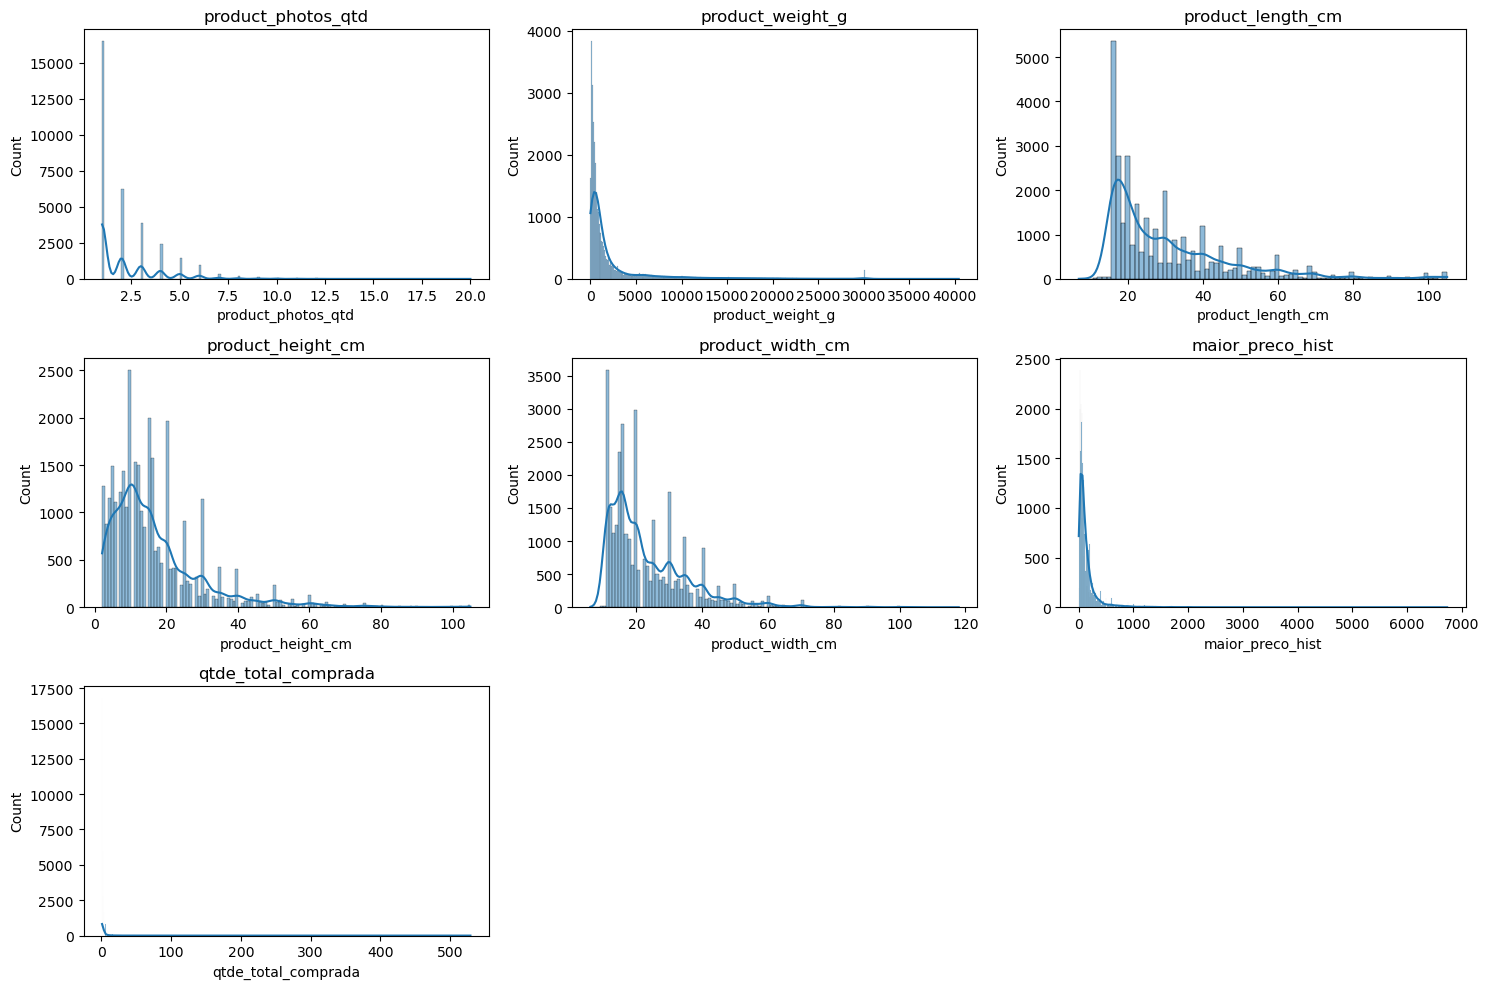

In [77]:
# Determine the layout of subplots based on the number of variables
num_cols = 3  # Number of columns in your subplot grid
num_rows = (modelar.shape[1] // num_cols) + 1  # Number of rows needed
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))

axes = axes.flatten()
for i, col in enumerate(modelar.columns):
    sns.histplot(data=modelar[col], ax=axes[i], kde=True)
    axes[i].set_title(col)  # Set variable name as title

for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()

In [78]:
SEED = 1224
pca_pipeline = Pipeline([('scaler', StandardScaler()), ('PCA', PCA(n_components=2, random_state=SEED))])
Pipeline_pca_2 = pca_pipeline.fit_transform(modelar)
projection = pd.DataFrame(columns=['x', 'y'], data=Pipeline_pca_2)

Extraí o modelo PCA do Pipeline

In [79]:
Modelo_PCA = pca_pipeline.named_steps['PCA']

Extraí os componentes do modelo

In [80]:
pca_components = Modelo_PCA.components_

Entendendo a relação de dependencia linear de cada variável na criação dos PCAs

In [81]:
# Create a DataFrame to show how each variable contributes to each PC
pc_columns = [f'PC{i+1}' for i in range(pca_components.shape[0])]
variables = list(modelar.columns)  # Replace with your actual variable names
df_components = pd.DataFrame(pca_components.T, columns=pc_columns, index=variables)

# Display the DataFrame
print(df_components)

                          PC1       PC2
product_photos_qtd   0.055708  0.968493
product_weight_g     0.546148 -0.064761
product_length_cm    0.444105  0.058172
product_height_cm    0.418062 -0.158798
product_width_cm     0.483089 -0.046446
maior_preco_hist     0.304775  0.140434
qtde_total_comprada -0.018740 -0.085714


Aqui podemos Observar que:
- Primeiro Componente: Pode ser explicado pela combinação dos dados que formam a dimensão do produto
- Segundo Componente: Altamente explicado pela quantidade de fotos que temos do produto

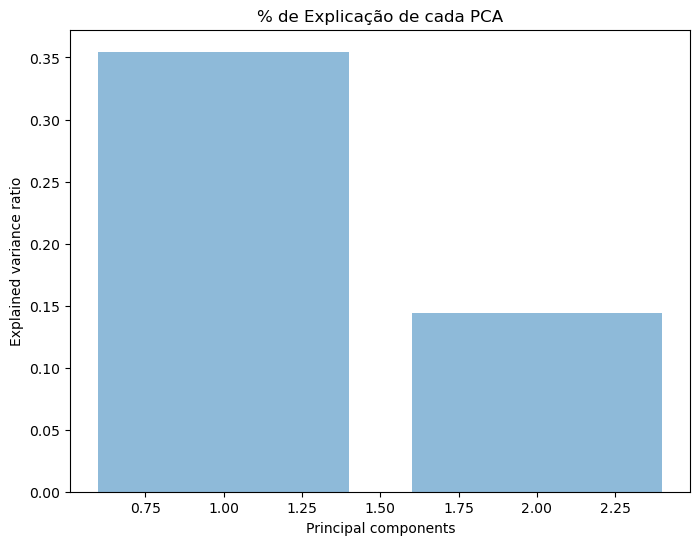

In [82]:
# Access the explained variance ratio
explained_variance = Modelo_PCA.explained_variance_ratio_
plt.figure(figsize=(8, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.5, align='center')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.title('% de Explicação de cada PCA')
plt.show()

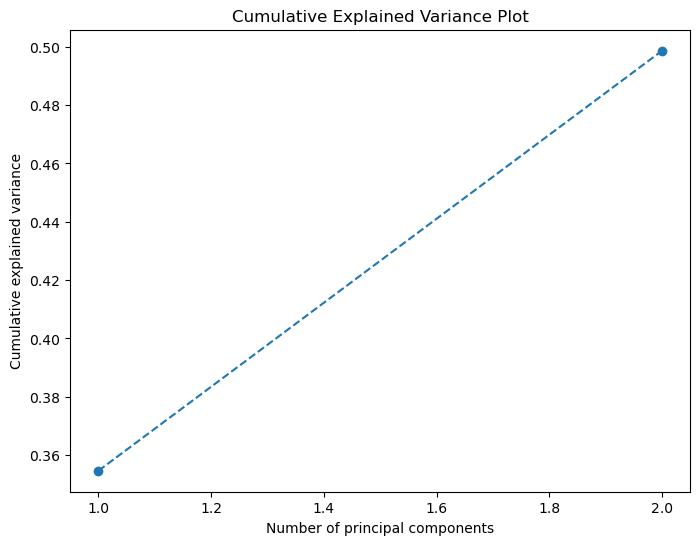

In [83]:
cumulative_variance = np.cumsum(explained_variance)

# Plot cumulative explained variance
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.ylabel('Cumulative explained variance')
plt.xlabel('Number of principal components')
plt.title('Cumulative Explained Variance Plot')
plt.show()

Aqui podemos observar que apenas 2 PCAs não são suficientes para resumir nossos dados.
Porém, iremos plotar a projeção para entender como se comporta o Kmeans

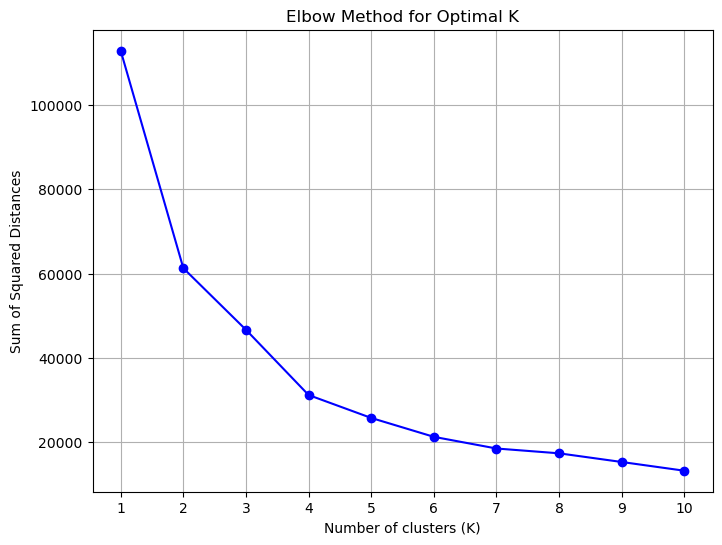

In [84]:
# Fit KMeans clustering for a range of K values
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=SEED)
    kmeans.fit(projection)
    sse.append(kmeans.inertia_)  # Sum of squared distances to closest cluster center

# Plotting the elbow curve
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), sse, marker='o', linestyle='-', color='b')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method for Optimal K')
plt.xticks(np.arange(1, 11, 1))
plt.grid(True)
plt.show()

Aqui podemos ver que entre 5 e 9 seriam os valores ideais para se trabalhar. \
Iremos plotar o com 5 para termos uma visualização dos clusters

In [85]:
kmeans_pca = KMeans(n_clusters=5, verbose=2, random_state=SEED)

kmeans_pca.fit(projection)

Initialization complete
Iteration 0, inertia 31598.002384724234.
Iteration 1, inertia 26744.26595590543.
Iteration 2, inertia 26152.915414658804.
Iteration 3, inertia 25940.581017845376.
Iteration 4, inertia 25871.679667133205.
Iteration 5, inertia 25839.719462454053.
Iteration 6, inertia 25816.244324940184.
Iteration 7, inertia 25798.039171380682.
Iteration 8, inertia 25785.84355148598.
Iteration 9, inertia 25776.078481094097.
Iteration 10, inertia 25767.2717993188.
Iteration 11, inertia 25759.486768271396.
Iteration 12, inertia 25754.627547014337.
Iteration 13, inertia 25749.634903200862.
Iteration 14, inertia 25746.650499984706.
Iteration 15, inertia 25745.723230772972.
Converged at iteration 15: center shift 6.322275367426106e-05 within tolerance 0.0001745359451099232.


KMeans(n_clusters=5, random_state=1224, verbose=2)

In [86]:
projection['cluster_calculado'] = kmeans_pca.predict(projection)

<Axes: xlabel='x', ylabel='y'>

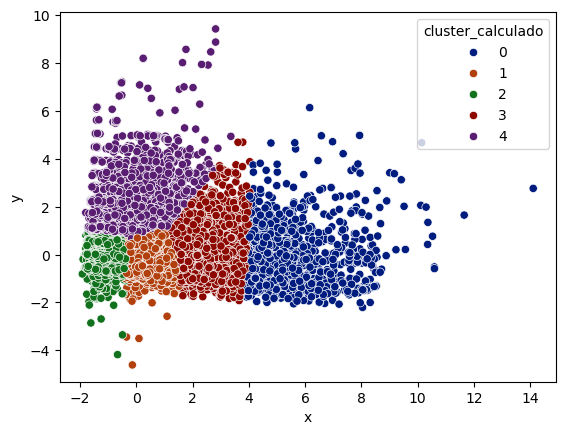

In [87]:
sns.scatterplot(
   data=projection, x='x', y='y', hue='cluster_calculado',palette='dark')

Utilizando o que podemos ver das analises anteriores vamos utilizar:
- Standar Scaler para normalizar nossos dados e deixá-los em um mesmo range;
- Não iremos utilizar a variável de qtde total comprada, uma vez que ela não teve nenhum impacto nos PCAs analisados.
- Utilizar um n_components no PCA a fim de explicar, no mínimo, 70% de nossa variância
- Utilizar entre 5 e 9 clusters

### Base completa

In [88]:
modelar2 = cubo_final.drop(['product_id','qtde_total_comprada'],axis='columns')

In [89]:
modelar2 = pd.get_dummies(modelar2)

In [90]:
Pipeline_Final = Pipeline([('scaler', StandardScaler()), ('PCA', PCA(n_components=0.7, random_state=SEED))])

In [91]:
Pipeline_Final_1 = Pipeline_Final.fit_transform(modelar2)

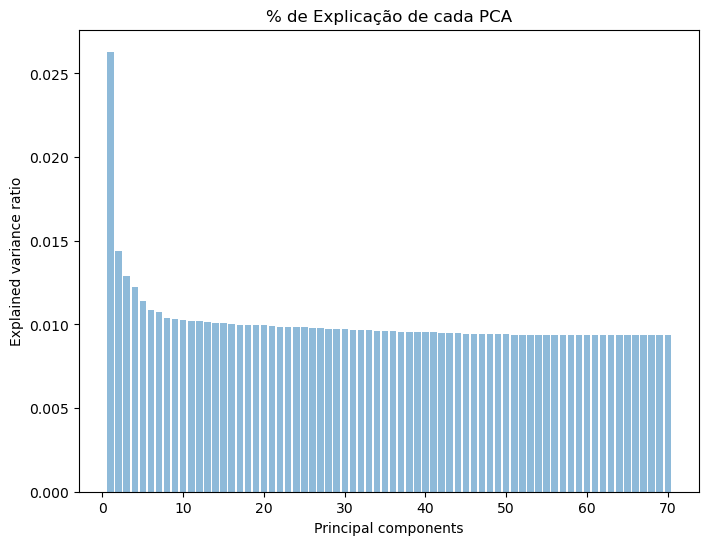

In [92]:
explained_variance = Pipeline_Final.named_steps['PCA'].explained_variance_ratio_
plt.figure(figsize=(8, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.5, align='center')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.title('% de Explicação de cada PCA')
plt.show()

Modela o Kmeans

In [93]:
# kmeans_final = KMeans(n_clusters=5, verbose=2, random_state=SEED)

In [94]:
Projecao = pd.DataFrame(data=Pipeline_Final_1)

In [95]:
cluster_counts = [5, 6, 7,8, 9]
for n_clusters in cluster_counts:
    # Criação e ajuste do modelo K-means
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=100, random_state=SEED)
    kmeans.fit(Projecao)
    
    # Predição dos rótulos dos clusters
    labels = kmeans.labels_
    
    # Cálculo da inércia
    inertia = kmeans.inertia_
    
    # Cálculo do Silhouette Score
    if n_clusters > 1:  # Silhouette Score não é definido para 1 cluster
        silhouette_avg = silhouette_score(Projecao, labels)
    else:
        silhouette_avg = None
    
    # Exibição dos resultados
    print(f'Número de clusters: {n_clusters}')
    print(f'Inércia: {inertia}')
    print(f'Silhouette Score: {silhouette_avg}')
    print('---')

Número de clusters: 5
Inércia: 2293003.8862077477
Silhouette Score: -0.03925625204129397
---
Número de clusters: 6
Inércia: 2270026.6916596456
Silhouette Score: 0.009599562775931575
---
Número de clusters: 7
Inércia: 2242804.628145715
Silhouette Score: 0.01790182134826526
---
Número de clusters: 8
Inércia: 2218316.784305897
Silhouette Score: 0.02734475788955485
---
Número de clusters: 9
Inércia: 2190412.3764259834
Silhouette Score: 0.038288426741534834
---


Sendo assim, podemos verificar que, com 8 clusters, obtemos uma baixa significativa de inercia (se comparada à opção de 5 clusters) e o aumento do silhouette para de ser significativo

Coloca o cluster de cada produto de volta no cubo_final

In [96]:
kmeans_final = KMeans(n_clusters=8, init='k-means++', max_iter=100, random_state=SEED)
kmeans_final.fit(Projecao)

KMeans(max_iter=100, random_state=1224)

In [97]:
cubo_final['cluster_kmeans'] = kmeans_final.predict(Projecao)
Projecao['cluster_kmeans'] = kmeans_final.predict(Projecao)
Projecao['product_id'] = cubo_final['product_id']

In [98]:
cubo_final.head()

,product_id,product_category_name,product_photos_qtd,product_weight_g,product_length_cm,product_height_cm,product_width_cm,maior_preco_hist,qtde_total_comprada,UF_mais_freq,cluster_kmeans
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,1.0,225.0,16.0,10.0,14.0,10.91,1,SP,6
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,1.0,1000.0,30.0,18.0,20.0,248.00,1,RJ,6
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,1.0,154.0,18.0,9.0,15.0,79.80,1,SP,6
3,cef67bcfe19066a932b7673e239eb23d,bebes,1.0,371.0,26.0,4.0,26.0,112.30,1,SP,6
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,4.0,625.0,20.0,17.0,13.0,37.90,1,SP,1


In [99]:
Projecao['product_category_name'] = cubo_final['product_category_name']

# 4.Sistema de Recomendação

In [100]:
produto_escolhido = 'b2b3503e675abbc07e278151da072ed2'

In [101]:
cubo_final[cubo_final.product_id == produto_escolhido]

,product_id,product_category_name,product_photos_qtd,product_weight_g,product_length_cm,product_height_cm,product_width_cm,maior_preco_hist,qtde_total_comprada,UF_mais_freq,cluster_kmeans
103,b2b3503e675abbc07e278151da072ed2,moveis_decoracao,1.0,8500.0,75.0,25.0,55.0,199.99,1,SP,0


In [102]:
from sklearn.metrics.pairwise import euclidean_distances

cluster = list(Projecao[Projecao['product_id']== produto_escolhido]['cluster_kmeans'])[0]
produtos_recomendadas = Projecao[Projecao['cluster_kmeans']== cluster]
array_produto_escolhido = Projecao[Projecao['product_id']== produto_escolhido].iloc[:,:-3]
#distâncias euclidianas
distancias = euclidean_distances(produtos_recomendadas.iloc[:,:-3], array_produto_escolhido)
# produtos_recomendadas['id'] = cubo_final['id']  
produtos_recomendadas['distancias']= distancias
recomendada = produtos_recomendadas.sort_values('distancias')
# recomendada[['product_id','cluster_kmeans','product_category_name','distancias']]

C:\Users\engca\AppData\Local\Temp\ipykernel_138152\1355891916.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  produtos_recomendadas['distancias']= distancias


In [103]:
recomendada[['product_id','cluster_kmeans','product_category_name','distancias']].head(10)

,product_id,cluster_kmeans,product_category_name,distancias
103,b2b3503e675abbc07e278151da072ed2,0,moveis_decoracao,5.960464e-08
6353,685a5d6795fa0aeafc83984918957827,0,moveis_decoracao,7.098526e-01
12006,0d8aaee3e75a9529a387b2e0e52615f5,0,moveis_decoracao,8.034031e-01
1603,d1f1c64b5ad001769bb3a6f20994cdd1,0,moveis_decoracao,8.484393e-01
7413,6961fec72a8f56ba5eff6d01b51f4d39,0,moveis_decoracao,8.756256e-01
29952,986d0d7a45258d4b8be60463fcff39f6,0,moveis_decoracao,9.712172e-01
24781,68486b30d9aa029461c1906bdcbf09df,0,moveis_decoracao,9.712172e-01
23202,55b07be78f0c20631dc3d53ff92bb292,0,moveis_decoracao,9.973060e-01
19881,4af7719ff3907f9e7f11a7652dfe5d90,0,moveis_decoracao,1.005169e+00
18178,919b08607e72077425654ac5fc0b5528,0,moveis_decoracao,1.037641e+00


Melhorias Futuras:
- Uma vez que temos os products_ids recomendados, poderíamos nos conectar à API do Olist para pegar a imagem e outras infos desses produtos, ou até "embedar" o nosso recomendador no sistema deles

# 5. Descritivo dos Clusters

In [108]:
lista_de_clusters = list(cubo_final.cluster_kmeans.unique())

In [109]:
lista_de_clusters.sort()

In [111]:
for i in range(len(lista_de_clusters)):
    print('Para o cluster %d temos os 5 principais grupos de produtos' % lista_de_clusters[i])
    print(cubo_final[cubo_final.cluster_kmeans == lista_de_clusters[i]].product_category_name.value_counts().head(5))
    print('------------------------------------------------------')

Para o cluster 0 temos os 5 principais grupos de produtos
product_category_name
moveis_decoracao         496
moveis_escritorio        307
bebes                    269
cama_mesa_banho          223
utilidades_domesticas    166
Name: count, dtype: int64
------------------------------------------------------
Para o cluster 1 temos os 5 principais grupos de produtos
product_category_name
utilidades_domesticas    2131
cama_mesa_banho           356
esporte_lazer             333
beleza_saude              303
malas_acessorios          281
Name: count, dtype: int64
------------------------------------------------------
Para o cluster 2 temos os 5 principais grupos de produtos
product_category_name
telefonia           1134
esporte_lazer        111
moveis_decoracao      85
beleza_saude          75
artigos_de_natal      65
Name: count, dtype: int64
------------------------------------------------------
Para o cluster 3 temos os 5 principais grupos de produtos
product_category_name
fashion_bolsas_e_

In [107]:
print('Quantidade em cada cluster:')
print(cubo_final.cluster_kmeans.value_counts())

Quantidade em cada cluster:
cluster_kmeans
6    18608
1     5472
0     3117
4     2202
2     1971
3      848
7       94
5       28
Name: count, dtype: int64


In [112]:
cubo_final.dtypes

product_id                object
product_category_name     object
product_photos_qtd       float64
product_weight_g         float64
product_length_cm        float64
product_height_cm        float64
product_width_cm         float64
maior_preco_hist         float64
qtde_total_comprada        int64
UF_mais_freq              object
cluster_kmeans             int32
dtype: object

In [114]:
pd.set_option('display.max_columns',60)
cubo_final.groupby(by='cluster_kmeans')[['product_photos_qtd',
                                         'product_weight_g',
                                         'product_length_cm',
                                         'product_height_cm',
                                         'product_width_cm',
                                         'maior_preco_hist',
                                         'qtde_total_comprada']].describe()

product_photos_qtd                                          \
                            count      mean       std  min  25%  50%  75%   
cluster_kmeans                                                              
0                          3117.0  2.475136  2.022921  1.0  1.0  2.0  3.0   
1                          5472.0  2.117325  1.671018  1.0  1.0  1.0  3.0   
2                          1971.0  2.491121  1.952818  1.0  1.0  2.0  3.0   
3                           848.0  2.942217  2.061673  1.0  1.0  3.0  4.0   
4                          2202.0  2.558129  1.751362  1.0  1.0  2.0  4.0   
5                            28.0  2.142857  1.603567  1.0  1.0  1.5  3.0   
6                         18608.0  2.048957  1.632627  1.0  1.0  1.0  3.0   
7                            94.0  2.819149  1.923051  1.0  1.0  2.0  4.0   

                     product_weight_g                                    \
                 max            count          mean          std    min   
cluster_kmeans                                                            
0               20.0           3117.0  11697.885467  7369.504708   50.0   
1               18.0           5472.0   1655.856725  2315.841792    2.0   
2               13.0           1971.0    643.927448  1266.996299   50.0   
3               15.0            848.0    402.385613  1281.003681   50.0   
4               10.0           2202.0   2174.237511  3191.630732   50.0   
5                7.0             28.0    795.785714  1106.533069  100.0   
6               17.0          18608.0   1107.211791  1438.628391    0.0   
7                8.0             94.0  11598.563830  8925.999669   50.0   

                                                    product_length_cm  \
                    25%      50%       75%      max             count   
cluster_kmeans                                                          
0               6400.00  10100.0  15800.00  40425.0            3117.0   
1                400.00    800.0   1750.00  26100.0            5472.0   
2                150.00    300.0    550.00  21200.0            1971.0   
3                100.00    200.0    250.00  18100.0             848.0   
4                300.00    800.0   2550.00  23250.0            2202.0   
5                150.00    375.0    912.50   5500.0              28.0   
6                300.00    600.0   1300.00  22175.0           18608.0   
7               3906.25   9950.0  16881.25  30000.0              94.0   

                                                                      \
                     mean        std   min   25%   50%    75%    max   
cluster_kmeans                                                         
0               55.261149  21.183133  13.0  40.0  52.0  65.00  105.0   
1               29.703765  14.049998  10.0  19.0  25.5  36.00  105.0   
2               22.997971  11.496634  11.0  17.0  19.0  23.00  105.0   
3               19.167453   7.761211  16.0  16.0  16.0  18.00  100.0   
4               32.704814  18.703285  12.0  18.0  25.0  40.00  105.0   
5               27.642857  16.382498   9.0  16.0  21.5  30.75   78.0   
6               28.172023  13.530552   7.0  18.0  24.0  35.00  105.0   
7               47.340426  24.444166  16.0  31.0  40.0  60.75  102.0   

               product_height_cm                                         \
                           count       mean        std  min   25%   50%   
cluster_kmeans                                                            
0                         3117.0  36.401668  21.862808  2.0  20.0  32.0   
1                         5472.0  17.775768  12.225011  2.0  10.0  15.0   
2                         1971.0  10.314054   8.434718  2.0   4.0   8.0   
3                          848.0   8.916274   8.563056  2.0   3.0   8.0   
4                         2202.0  15.704360  11.349244  2.0   8.0  14.0   
5                           28.0  11.571429   6.573959  2.0   5.0  12.0   
6                        18608.0  14.569809   9.427029  2.0   8.0  12

In [116]:
for i in range(len(lista_de_clusters)):
    print('Para o cluster %d temos os 5 principais grupos de produtos' % lista_de_clusters[i])
    print(cubo_final[cubo_final.cluster_kmeans == lista_de_clusters[i]].UF_mais_freq.value_counts().head(5))
    print('------------------------------------------------------')


Para o cluster 0 temos os 5 principais grupos de produtos
UF_mais_freq
SP    1325
RJ     449
MG     275
RS     162
PR     160
Name: count, dtype: int64
------------------------------------------------------
Para o cluster 1 temos os 5 principais grupos de produtos
UF_mais_freq
MG    3296
SP    1200
RJ     301
PR     133
RS     117
Name: count, dtype: int64
------------------------------------------------------
Para o cluster 2 temos os 5 principais grupos de produtos
UF_mais_freq
SC    732
SP    519
MG    168
RJ    124
BA     70
Name: count, dtype: int64
------------------------------------------------------
Para o cluster 3 temos os 5 principais grupos de produtos
UF_mais_freq
SP    358
MG    117
RJ     87
PR     40
BA     36
Name: count, dtype: int64
------------------------------------------------------
Para o cluster 4 temos os 5 principais grupos de produtos
UF_mais_freq
SP    756
MG    282
RJ    217
PI    135
PR    101
Name: count, dtype: int64
-----------------------------------

Descritivo das Ufs e dimensões e preço do produto

In [117]:
cubo_final.product_category_name.value_counts()

product_category_name
cama_mesa_banho                  3029
esporte_lazer                    2867
moveis_decoracao                 2657
beleza_saude                     2444
utilidades_domesticas            2335
                                 ... 
fashion_roupa_infanto_juvenil       5
casa_conforto_2                     5
pc_gamer                            3
seguros_e_servicos                  2
cds_dvds_musicais                   1
Name: count, Length: 73, dtype: int64

Descritivo Completo dos Clusters:

- Cluster 0 &rarr; Produtos para a casa, comprados geralmente no sudeste, produtos grandes (mais que 10kg) como móveis e com o preço mais altos dos clusters;

- Cluster 1 &rarr; Produtos de utilidades domésticas e lazer frequentemente comprados no MG e SP, são produtos menores para decoração como luminárias, saboreteiras etc, custando por volta de 100 reais;

- Cluster 2 &rarr; Produtos relacionados à telefonia, como carregadores, celulares etc. Espalhados pelo Brasil.

- Cluster 3 &rarr; Produtos de moda, como bolsa e acessórios. Tem poucos itens no cluster por se tratarem de muito específicos. São os produtos mais compactos dos clusters.

- Cluster 4 &rarr; Produtos relacionados à automóveis e bricolagem; São produtos pesados de menor dimensionalidade do que observado no cluster 1

- Cluster 5 &rarr; Produtos exclusivos da categoria cinema e foto, como câmeras, rebatedores de luz, etc. São produtos de menor peso com dimensões médias;

- Cluster 6 &rarr; É o maior cluster de todos, envolve produtos de cama, mesa e banho, produtos de esporte e lazer e beleza e saúde. Neste cluster temos produtos de menor dimensionalidade como cortinas, travesseiros, kits paraa bike, colchões infláveis

- Cluster 7 &rarr; Segundo menor cluster, que nos mostra produtos da categoria "moveis_cozinha_area_de_servico_jantar_e_jardim". São os segundo cluster de produtos muito pesados >10kg com as maiores dimensões dos clusters, nos indicando que são móveis dedicados aos cômodos de cozinha e área de serviço como pia, fogão, máquina de lavar, etc. 